In [1]:
from utilities import *

[Text(0.0, 0, '$t_1$'),
 Text(2.4746339798218666, 0, '$t_2 (t_3)$'),
 Text(7.462872553321062, 0, '$t_4$')]

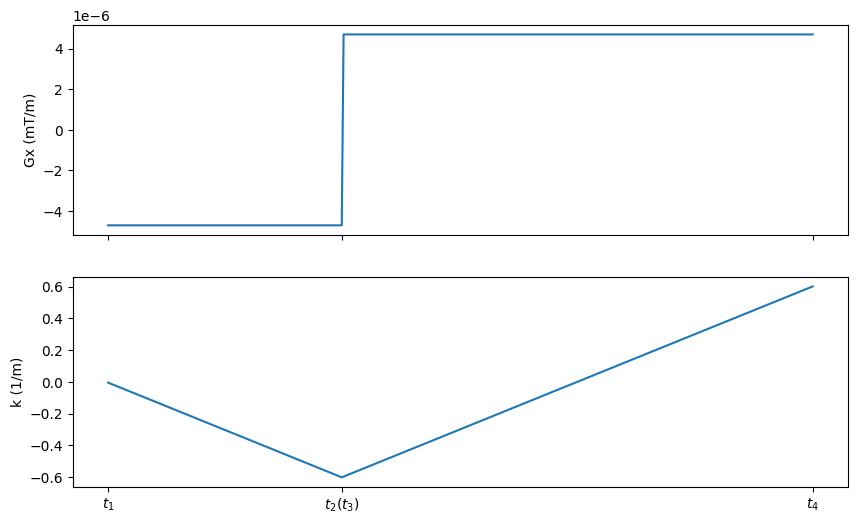

In [2]:
# Environment Setup

# x space (spatial space)
FOV_x = 256 # field of view in x space
N = 256 # sampling points in x space (and k space, time space during ADC)
delta_x = FOV_x / N # sampling interval in x space
x_axis = np.linspace(-FOV_x / 2, FOV_x / 2 - delta_x, N) # symmetric x space

# k space (frequency space)
delta_k = 1 / FOV_x # sampling interval in k space
FOV_k = delta_k * N # field of view in k space
k_axis = np.linspace(-FOV_k / 2, FOV_k / 2 - delta_k, N) # symmetric k space

# gradient
Gx = 4.7e-6 # gradient (T/mm). Note: constant gradient. if gradient is not constant, delta_t will change based on Gx and delta_k?
gamma = 2.68e8 # rad/s/T
gamma_bar = 0.5 * gamma/np.pi # s^-1T^-1

# t space (time space)

gamma_bar_Gx = gamma_bar * Gx * 1e-3
delta_t = delta_k / gamma_bar_Gx # sampling interval in t space (ms)
Ts = FOV_k / gamma_bar_Gx # ADC(rephasing) time (ms)
t_max = 1.5 * Ts - delta_t # maximum time (ms) (rephasing process is 2 times longer than dephasing process)
t_axis = np.linspace(0, t_max, int(N * 1.5))

# Environment Display

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 6))

G_values = np.concatenate((np.ones(int(N / 2)) * -Gx, np.ones(N) * Gx))
ax1.plot(t_axis, G_values)
ax1.set_ylabel('Gx (mT/m)')

k_traj = np.cumsum(G_values) * 1e3
ax2.plot(t_axis, k_traj)
ax2.set_ylabel('k (1/m)')

ax2.set_xticks([0, t_axis[int(N / 2) - 1], t_axis[int(N * 1.5) - 1]])
ax2.set_xticklabels(['$t_1$', r'$t_2 (t_3)$', r'$t_4$'])

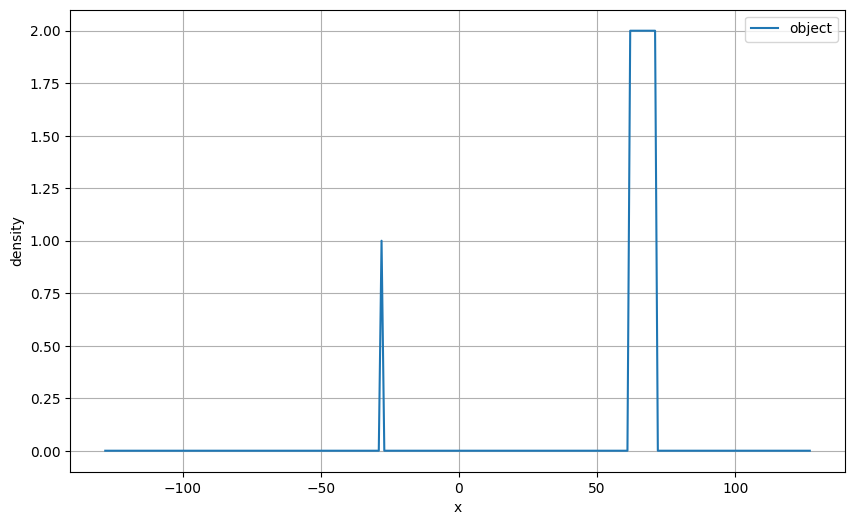

In [3]:
# create object
density = np.zeros(len(x_axis))
density[100] = 1
density[190:200] = 2

plt.figure(figsize=(10, 6))
plt.plot(x_axis, density, '-', label='object')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.grid()

[-0.49833426 -1.01376089 -1.2983255   0.63873542  2.08799356  0.36220238
 -0.76657084  1.04091475  0.99568015 -2.18748855]
[ 0.13558566 -1.17950613 -0.69452313  0.14297243 -1.040265   -1.28393875
  1.49480388  2.52541073 -0.26104417 -1.24723667]


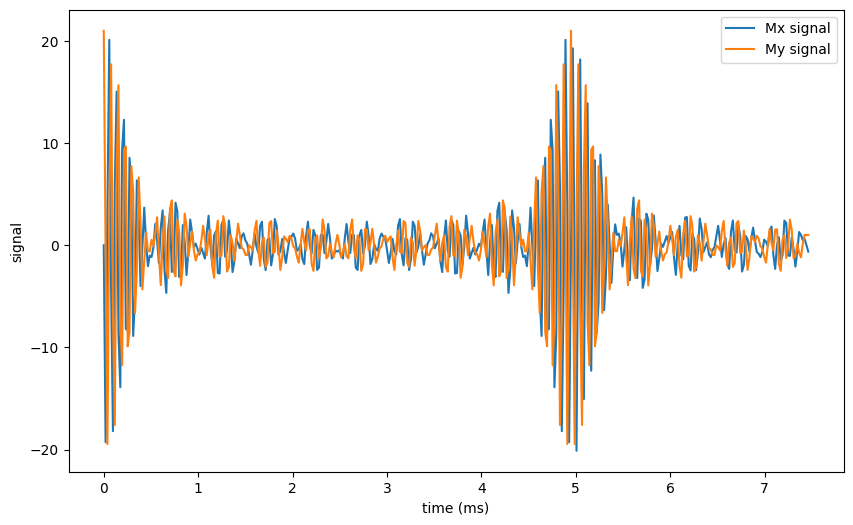

In [4]:
# create spins after the rf pulse (lying on the y-axis)
# assume the spins are lying on each sampling point over y-axis
m0 = 1.0
w_0 = 0
vec_spins = np.zeros((3, N))
vec_spins[1, :] = 1

# define larmor frequency w_G of spins during relaxation
# shape = (number of time steps, number of sampling points)
w_G = np.outer(G_values, x_axis) * gamma * 1e-3 + w_0

res = multiple_Relaxation(vec_spins, m0=m0, w=0, w0=w_G, t1=1e10, t2=1e10, t=1.5*Ts, steps=int(N*1.5), axis='z')

store = []
for i in range(2):
    tmp = res[i,:,:].squeeze() # shape: (number of steps, number of sampling points)
    
    store.append(tmp @ density) # multiply by true density

Mx_1, My_1 = store[0][:int(N/2)], store[1][:int(N/2)]
Mx_2, My_2 = store[0][int(N/2):], store[1][int(N/2):]

# plot the full signal
signal_Mx = np.concatenate((Mx_1, Mx_2), axis=0)
signal_My = np.concatenate((My_1, My_2), axis=0)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(t_axis, signal_Mx, label='Mx signal')
plt.plot(t_axis, signal_My, label='My signal')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('signal')

print(Mx_2[:10])
print(My_2[:10])


Text(0, 0.5, 'reconstructed phase')

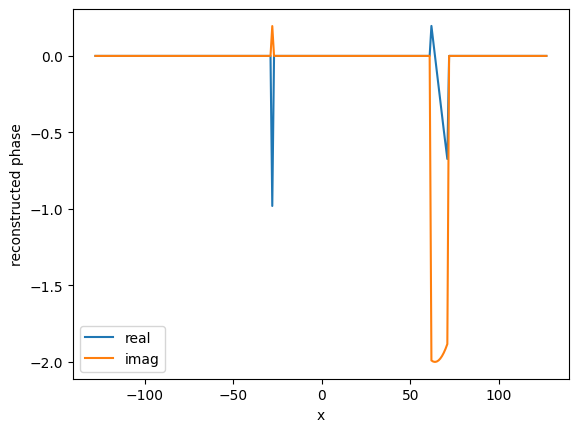

In [5]:
# ifft of the signal when the ADC on
adc_signal = Mx_2 * 1 + 1j * My_2

re_density = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(adc_signal)))
plt.plot(x_axis, np.real(re_density), label='real')
plt.plot(x_axis, np.imag(re_density), label='imag')
plt.legend()
plt.xlabel('x')
plt.ylabel('reconstructed phase')


-8.939426776122348e-09

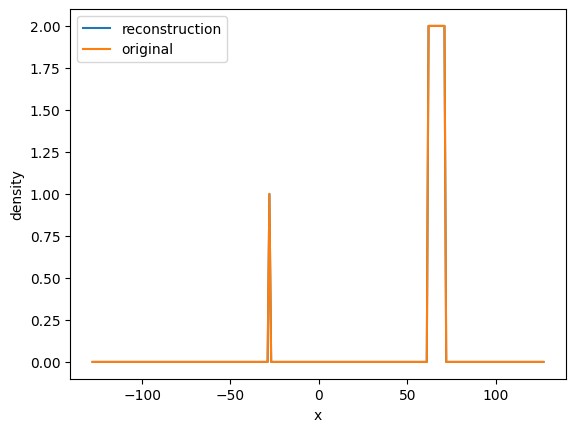

In [6]:
# plot the absolutely reconstructed density
plt.plot(x_axis, np.abs(re_density), label='reconstruction')
plt.plot(x_axis, density, label='original')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')

# calculate the error
error = np.sum(np.abs(re_density) - density)
error


In [7]:
# display the trajectory of a spin in xy plane
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a random array with shape (2,100)
np.random.seed(0)
positions = np.random.rand(2, 100)
positions[0, :] = res[0, 128:228, 127 - 60].transpose()
positions[1, :] = res[1, 128:228, 127 - 60].transpose()
fig, ax = plt.subplots()
point, = ax.plot([], [], 'go')  # Start with an empty plot
ax.set_xlim(-2, 2)  # Set the limits of the plot
ax.set_ylim(-2, 2)

# Initialization function: plot the background of each frame
def init():
    point.set_data([], [])
    return point,

# Animation function: this is called sequentially
def animate(i):
    x = positions[0, i]
    y = positions[1, i]
    point.set_data(x, y)
    return point,

# Call the animator
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=200, blit=True)

ani.save('animation-60.gif', writer='pillow')

plt.close()

from IPython.display import Image

Image(url='animation+60.gif')